# **Trial**

In [1]:
import json
import jieba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from gensim.models.ldamodel import LdaModel
from gensim import corpora, models
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from transformers import BertModel, BertTokenizer

In [2]:
json_path = r'C:\Users\11435\Desktop\clutter\research\data\stock\BV1LuxZeVE25.json'

with open(json_path, 'r', encoding='utf-8') as file:
    # 加载 JSON 数据
    data = json.load(file)
    
doc_data = [info['review'] for info in data]
doc_data

['22年入市，昨天早上几乎最高位离场，达到预期收益就收手，纪律性是对抗贪婪本性的唯一办法[OK]',
 '今天已经暴跌了，但是我认为下午会有国家队。。。这才第二天就砸盘这么猛，主力有点不给面子了，盲猜收盘之前会翻红，但是也让散户看明白了，什么政策什么经济复苏，还是那套玩意，就是嘎散户的钱，盲目入坑的绝对冷静了[doge_金箍]反正我是没入，不亏就是赚了',
 '昨天在店内一边吃鸡翅一边用手机看股票。一个乞丐进来乞讨，我给他一块鸡翅后继续看股票。乞丐啃着鸡翅没走，也在一旁看着，他说：“长期均线金叉，KDJ数值底部反复钝化，MACD底背离，能量潮喇叭口扩大，这股要涨了。”我惊诧地问：“这个你也懂？” 乞丐说：“不懂我能有今天？”',
 '几天的大阳线把股民们以前的记忆都干没了[doge]，你们根本不知道有多疯狂，我一个从未接触过股票的朋友都开户来问我怎么玩了，你可知道他竟然连板块都不会找股票代码什么是沪深的也不知道就投了几万块进去',
 '经历2008年股灾的老人回忆到，股市有政策底，还有市场底。政策到位，上涨一轮，引人下场后再跌停，让你来不及逃生。我巨亏40%，狠狠心抛了，逃过了后面的下跌。',
 '一个特别微观又直观的例子：大家可以看下各银行的大额存单转让区，这里基本都是居民存款，节前转让收益率上升了10-20bp。说明这轮行情真真实实的撬动了银行存款，之前那么多zc没办到的事情这次竟然办到了。',
 '我始终坚信，一个赌场般的市场，绝对不会让大多数人赚到钱。',
 '今天已经开始技术性回调了[脱单doge]',
 '别人都是看涨，导致目前赛道过于拥挤。而老王直接看空，以此来安慰没上车的群体，别出心裁、另辟蹊径。看似在谈经济，实则在玩自媒体。老王高啊[支持]',
 '无论是涨是跌，最终能赚到并且保住这些钱的人都是极少数人，关键在于能不能清晰地认识到在这些人里面包不包括自己。',
 '我重申一下：股市是穷人最少的地方，中产最多的地方。\n在股市放水，造成的结果就是，中产变成富人，穷人还是穷人。\n【Doge】动动猪脑子想想，穷人能有多少钱玩？万儿八千，好点的十万八万，顶天了。\n富人可是百万千万。\n股市翻一倍，富人100万变200万，穷人5万变10万。\n\n 贫富差距增加了 = 最终贫富差距 - 初始贫富差距 = 190万 - 95万 = 95万\n\n因此。\

In [3]:
# 读取停用词，并去停用词
stopwords_path1 = r'C:\Users\11435\Desktop\clutter\research\data\corpus\stopwords_scu.txt'
with open(stopwords_path1, 'r', encoding='utf-8') as f:
    stopwords1 = set([line.strip() for line in f])

stopwords_path2 = r'C:\Users\11435\Desktop\clutter\research\data\corpus\stopwords_hit.txt'
with open(stopwords_path2, 'r', encoding='utf-8') as f:
    stopwords2 = set([line.strip() for line in f])

stopwords = stopwords1.union(stopwords2)

texts = []
for doc in doc_data:
    words = jieba.cut(doc)
    filter_words = [word for word in words if word not in stopwords and word.strip() != '']
    texts.append(filter_words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\11435\AppData\Local\Temp\jieba.cache
Loading model cost 0.504 seconds.
Prefix dict has been built successfully.


In [4]:
# 过滤频次
FREQ_LIMIT = 1
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > FREQ_LIMIT]for text in texts]

In [5]:
# 构建词典和语料库
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [6]:
# 训练多个LDA模型，并计算每个模型的困惑度
models_perplexity = []
num_topics_range = range(2, 21)  # 从2到20个主题

for num_topics in num_topics_range:
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    perplexity = lda_model.log_perplexity(corpus)
    models_perplexity.append((num_topics, perplexity))

# 打印每个模型的主题数和困惑度
for num_topics, perplexity in models_perplexity:
    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}")

# 选择困惑度最低的模型
best_num_topics = min(models_perplexity, key=lambda x: x[1])[0]
print(f"Best number of topics: {best_num_topics}")

Number of Topics: 2, Perplexity: -4.523738746531308
Number of Topics: 3, Perplexity: -4.55726279062219
Number of Topics: 4, Perplexity: -4.488229854032397
Number of Topics: 5, Perplexity: -4.525263579795137
Number of Topics: 6, Perplexity: -4.49866301426664
Number of Topics: 7, Perplexity: -4.5526154530234635
Number of Topics: 8, Perplexity: -4.5836647662799805
Number of Topics: 9, Perplexity: -4.666694604791701
Number of Topics: 10, Perplexity: -4.661523489980027
Number of Topics: 11, Perplexity: -4.604664154583588
Number of Topics: 12, Perplexity: -4.731867375550792
Number of Topics: 13, Perplexity: -4.762198238633573
Number of Topics: 14, Perplexity: -4.770978930406272
Number of Topics: 15, Perplexity: -4.691590656293556
Number of Topics: 16, Perplexity: -4.841862112982199
Number of Topics: 17, Perplexity: -4.863777047488838
Number of Topics: 18, Perplexity: -4.809053752804175
Number of Topics: 19, Perplexity: -4.811820663278922
Number of Topics: 20, Perplexity: -4.795252577401698
B

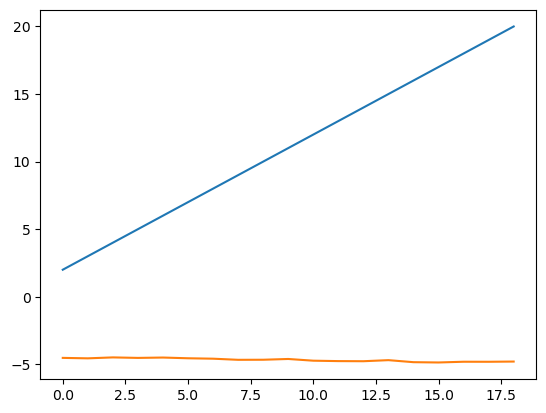

In [7]:
plt.plot(models_perplexity)

In [8]:
num_topic = 5
lda = models.LdaModel(corpus, num_topics=num_topic, id2word=dictionary, passes=15)

In [9]:
from gensim.models.coherencemodel import CoherenceModel

# 计算主题一致性
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print('Coherence Score: ', coherence_score)

Coherence Score:  0.5530402815315841


In [10]:
CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass').get_coherence()

-10.886810756384701

In [52]:
def topic_data_fill(topic_distribution, topic_num):
    features = []
    if len(topic_distribution) < topic_num:
        features = np.zeros(topic_num).tolist()
        for topic in topic_distribution:
            features[topic[0]] = topic[1]
    else:
        features = [topic[1] for topic in topic_distribution]
    return features

# 提取主题向量
lda_features = []
for document in corpus:
    topic_distribution = lda.get_document_topics(document)
    lda_features.append(topic_data_fill(topic_distribution, 5))

In [29]:
topics = lda.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.072*"万" + 0.072*"穷人" + 0.060*"贫富差距" + 0.048*"增加"')
(1, '0.048*"经济" + 0.048*"散户" + 0.048*"高位" + 0.048*"接盘"')
(2, '0.077*"贪婪" + 0.058*"调整" + 0.058*"恐惧" + 0.049*"点"')
(3, '0.109*"doge" + 0.084*"都" + 0.046*"赚钱" + 0.046*"涨"')
(4, '0.076*"都" + 0.061*"不" + 0.061*"人" + 0.047*"没"')


In [56]:
# 检测程序
for idx, features in enumerate(lda_features):
    if len(features) < 5:
        print(idx)

In [53]:
lda_features

[[0.0666713, 0.066675246, 0.7332992, 0.06668146, 0.06667282],
 [0.014358741, 0.9422135, 0.014374056, 0.014582295, 0.014471464],
 [0.9675566, 0.0, 0.0, 0.0, 0.0],
 [0.01336838, 0.013522732, 0.013396139, 0.0136795435, 0.9460332],
 [0.022514543, 0.022406977, 0.91019, 0.022232354, 0.022656156],
 [0.018209958, 0.018394316, 0.018244436, 0.018232977, 0.92691827],
 [0.03339818, 0.033581927, 0.033783875, 0.03334335, 0.86589265],
 [0.050142616, 0.050672363, 0.05012305, 0.7990039, 0.050058074],
 [0.025153475, 0.89887404, 0.025136646, 0.025176534, 0.025659302],
 [0.0223808, 0.022420384, 0.022389313, 0.022754857, 0.9100546],
 [0.983284, 0.0, 0.0, 0.0, 0.0],
 [0.020148303, 0.020268064, 0.020066217, 0.020046353, 0.919471],
 [0.066968866, 0.066674516, 0.066910475, 0.7319446, 0.06750155],
 [0.050004303, 0.796373, 0.05020461, 0.05209535, 0.05132273],
 [0.02521658, 0.025109377, 0.025180638, 0.025073107, 0.8994203],
 [0.033459716, 0.03369006, 0.03342471, 0.86537135, 0.034054145],
 [0.068290435, 0.72967273

In [12]:
# 加载已经训练好的bert模型
model_path = r'D:\tool\toolkit\nlp\distiluse-base-multilingual-cased-v2-finetuned-stsb_multi_mt-es'
model = BertModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
D:\tool\miniconda3\envs\allInOne\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertModel were not initialized from the model checkpoint at D:\tool\toolkit\nlp\distiluse-base-multilingual-cased-v2-finetuned-stsb_multi_mt-es and are newly initialized: ['embeddings.token_type_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.la

In [13]:
bert_features = []
for article in doc_data:
    # 对文章进行分词和编码
    encoded_input = tokenizer(article, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # 获取模型的输出
    with torch.no_grad():
        outputs = model(**encoded_input)
    # 获取CLS token的嵌入作为文章的特征向量
    bert_features.append(outputs.last_hidden_state[:, 0, :].squeeze().detach().numpy())

In [54]:
# lda和bert特征拼接
concatenated_features = []
for bert_feature, lda_feature in zip(bert_features, lda_features):
    # 将BERT特征向量和LDA主题向量拼接
    concatenated_feature = np.concatenate((bert_feature, lda_feature))
    concatenated_features.append(concatenated_feature)

In [15]:
# 定义自编码器
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(AutoEncoder, self).__init__()

        self.encoder  = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.en_fc = nn.Linear(64, hidden_size)
        self.de_fc = nn.Linear(hidden_size, 64)
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        en = self.encoder(x)
        code = self.en_fc(en)
        de = self.de_fc(code)
        decoded = self.decoder(de)
        return code, decoded

In [74]:
# 准备数据
# 模型默认参数为float32，如果想要用double(float64)来训练的话，model=model.double()
tensor_data = torch.tensor(concatenated_features, dtype=torch.float32)
dataset = TensorDataset(tensor_data)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 开始训练
HIDDEN_SIZE = 32
input_dim = len(concatenated_features[0])

model = AutoEncoder(input_dim, HIDDEN_SIZE)
criterion = nn.MSELoss()  # 均方误差损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
model = model.to("cpu")
epochs = 5
for epoch in range(epochs):
    for batch_idx, (data,) in enumerate(data_loader):
        # 正向传播
        outputs = model(data)[1]
        loss = criterion(outputs, data)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Batch [1/1], Loss: 0.9966
Epoch [2/5], Batch [1/1], Loss: 0.9836
Epoch [3/5], Batch [1/1], Loss: 0.9666
Epoch [4/5], Batch [1/1], Loss: 0.9431
Epoch [5/5], Batch [1/1], Loss: 0.9095


In [24]:
# 提取文本encoder后的结果
encoder_features = model(dataset)[0].item()

773

In [70]:
# 对encoder_features进行聚类分析

from sklearn.cluster import KMeans

# 假设 encoder_features 是一个二维数组，其中每一行是一个文档的特征向量
# texts 是原始文本数据列表

# 使用 K-means 算法进行聚类，设置聚类数目为 5
kmeans = KMeans(n_clusters=5, random_state=42).fit(encoder_features)

# 获取每个文档的聚类标签
cluster_labels = kmeans.labels_

from sklearn.feature_extraction.text import TfidfVectorizer

# 假设 vectorizer 是之前用于将文本转换为特征向量的 TF-IDF 向量化器
vectorizer = TfidfVectorizer()

# 获取特征名称（词汇）
feature_names = vectorizer.get_feature_names_out()

# 为每个聚类提取主题词
def get_cluster_topic(cluster_label):
    # 选择当前聚类的所有文档
    cluster_docs = [doc for doc_idx, label in enumerate(cluster_labels) if label == cluster_label]
    
    # 将文档转换为词袋模型
    cluster_bow = [vectorizer.transform([doc]) for doc in cluster_docs]
    
    # 计算每个词在当前聚类中的总TF-IDF值
    cluster_word_tfidf_sum = sum(cluster_bow)
    
    # 获取每个词的总TF-IDF值，并按降序排列
    word_tfidf_scores = cluster_word_tfidf_sum.toarray().flatten().tolist()
    word_tfidf_scores = sorted(enumerate(word_tfidf_scores), key=lambda x: x[1], reverse=True)
    
    # 返回TF-IDF值最高的N个词作为主题词
    top_n_words = set([feature_names[word_idx] for word_idx, _ in word_tfidf_scores[:10]])
    return top_n_words

# 为每个聚类提取主题词
cluster_topics = {label: get_cluster_topic(label) for label in range(5)}

torch.Size([20, 773])

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 假设documents是原始文本数据列表
documents = ["text of document 1", "text of document 2"]

# 使用TF-IDF向量化文本
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)

# 应用K-means聚类
kmeans = KMeans(n_clusters=5).fit(X)

# 为每个簇提取主题词
def get_cluster_words(cluster_documents):
    words = vectorizer.get_feature_names_out()
    cluster_words = []
    for doc in cluster_documents:
        for word in doc.split():
            if word in words:
                cluster_words.append(word)
    # 计算词频并选择最常见的词
    freq_dist = nltk.FreqDist(cluster_words)
    common_words = freq_dist.most_common(10)
    return [word for word, freq in common_words]

# 为每个簇提取主题词
cluster_topics = {i: get_cluster_words(documents[k]) for i, k in enumerate(kmeans.labels_)}

ValueError: max_df corresponds to < documents than min_df

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 示例文本数据
documents = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

# 初始化TF-IDF向量化器
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# 将文本数据转换为TF-IDF特征矩阵
X = vectorizer.fit_transform(documents)

# 获取特征名称（词汇）
feature_names = vectorizer.get_feature_names_out()

# 查看每个文档的TF-IDF向量
print(X.toarray())

[[1.]
 [1.]
 [0.]
 [1.]]


In [86]:
# 查看每个文档的TF-IDF向量
print("Feature names:", feature_names)
print("TF-IDF Matrix:\n", X.toarray())

Feature names: ['document']
TF-IDF Matrix:
 [[1.]
 [1.]
 [0.]
 [1.]]


In [ ]:
dir_path = r'C:\Users\11435\Desktop\clutter\research\data\others\互动\互动\用户与公司问答-2010.xlsx'
df = pd.read_excel(dir_path)

In [ ]:
# 加载已经训练好的bert模型
model_path = r'D:\tool\toolkit\nlp\distiluse-base-multilingual-cased-v2-finetuned-stsb_multi_mt-es'
model = BertModel.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
bert_features = []
for article in doc_data:
    # 对文章进行分词和编码
    encoded_input = tokenizer(article, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # 获取模型的输出
    with torch.no_grad():
        outputs = model(**encoded_input)
    # 获取CLS token的嵌入作为文章的特征向量
    bert_features.append(outputs.last_hidden_state[:, 0, :].squeeze().detach().numpy())